In [1]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import os
from os import path
import torchmetrics as TM

In [3]:
t2img = T.ToPILImage()
img2t= T.ToTensor()
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

In [4]:
def save_model_checkpoint(model, cp_name):
    torch.save(model.state_dict(), os.path.join("root/", cp_name))


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def load_model_from_checkpoint(model, ckp_path):
    return model.load_state_dict(
        torch.load(
            ckp_path,
            map_location=get_device(),
        )
    )


def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")
# end if

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()


In [5]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

In [6]:
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)



In [7]:
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

In [8]:
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)


        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)


In [9]:
pets_train = OxfordIIITPetsAugmented(
    root='./data',
    split="trainval",
    target_types="segmentation",
    download=True,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root='./data',
    split="test",
    target_types="segmentation",
    download=True,
    **transform_dict,
)

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

100%|██████████| 791918971/791918971 [00:46<00:00, 17198712.24it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:03<00:00, 5893437.14it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

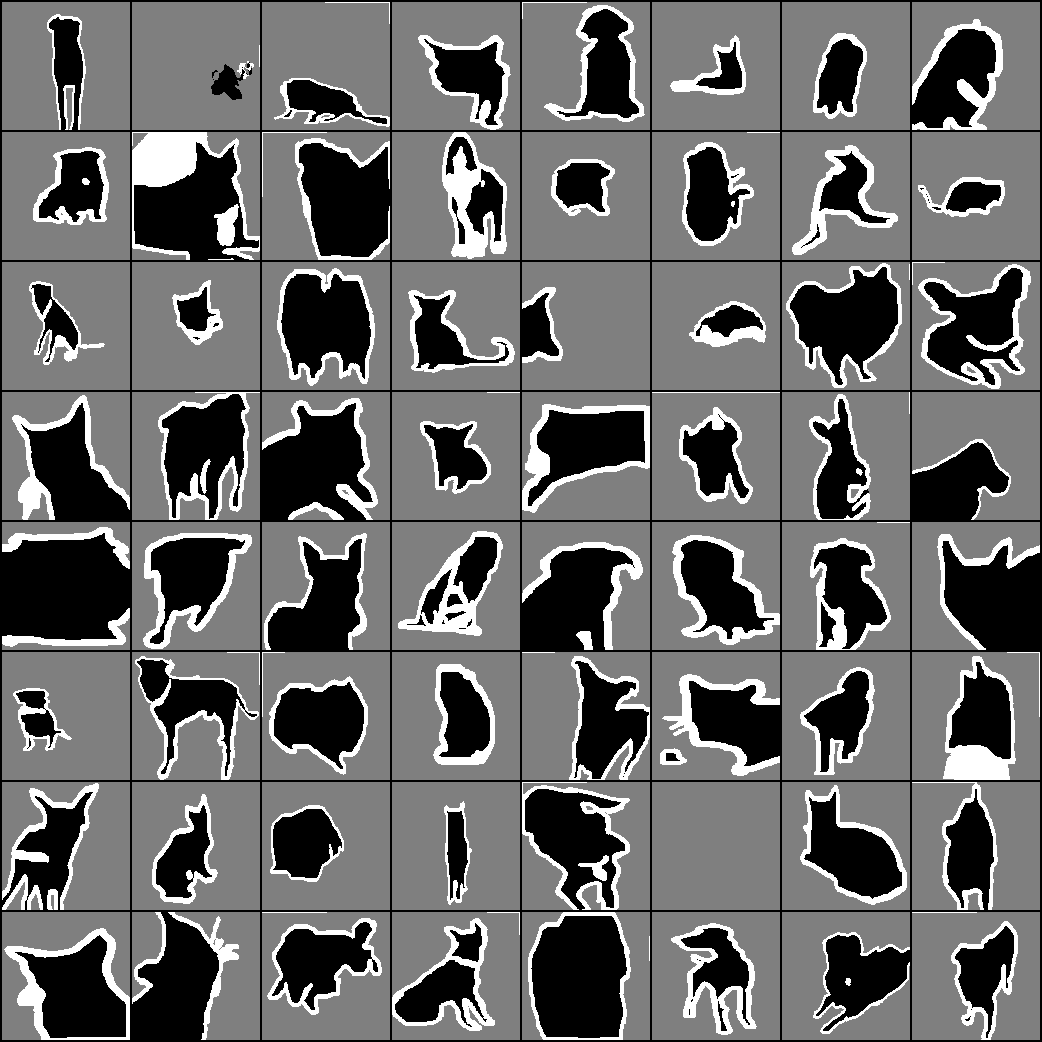

In [10]:
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets / 2.0, nrow=8)
t2img(pets_targets_grid)

In [11]:
tensor1 = torch.randn(2, 3, 4)  # shape: (2, 3, 4, 5)
tensor2 = torch.randn(2, 3, 4)  # shape: (2, 3, 4, 5)

# Concatenate along axis 3 (fourth dimension)
concatenated_tensor = torch.cat((tensor1, tensor2), dim=1)
concatenated_tensor.shape

torch.Size([2, 6, 4])

In [12]:
class DoubleConv(nn.Module):
  def __init__(self,chin,chout):
    super().__init__()
    self.seq = nn.Sequential(
          nn.Conv2d(in_channels=chin, out_channels=chout, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(chout),
          nn.ReLU(),
          nn.Conv2d(in_channels=chout, out_channels=chout, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(chout),
          nn.ReLU())
  def forward(self, x):
      return self.seq(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
                        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upconv= nn.ConvTranspose2d(in_channels,out_channels, kernel_size=2, stride=2)
        self.doubleConv=DoubleConv(in_channels, out_channels)
    def forward(self, x,y):
      x=self.upconv(x)
      x=torch.cat([x, y], dim=1)
      x=self.doubleConv(x)
      return x

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        y= F.softmax(self.conv(x))
        return y







In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels


        self.inc =  DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 )
        self.up1 =   Up(1024, 512)
        self.up2 =   Up(512, 256 )
        self.up3 =   Up(256, 128 )
        self.up4 =   Up(128, 64)
        self.outc =  OutConv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)

        x2 = self.down1(x1)

        x3 = self.down2(x2)

        x4 = self.down3(x3)

        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x


In [14]:
m=UNet(in_channels=3, out_channels=3)
m.eval()
to_device(m)
m(to_device(train_pets_inputs)).shape

<ipython-input-12-c61111d9766b>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y= F.softmax(self.conv(x))


torch.Size([64, 3, 128, 128])

In [24]:
def train_model(model, loader, optimizer):
    to_device(model.train())
    criterion = nn.CrossEntropyLoss(reduction='mean')



    running_loss = 0.0
    running_samples = 0

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        optimizer.zero_grad()
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)


        targets = targets.squeeze(dim=1)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_samples += targets.size(0)
        running_loss += loss.item()


    print("Trained {} samples, Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))

In [17]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()

def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    to_device(model.eval())
    predictions = model(to_device(test_pets_targets))
    test_pets_labels = to_device(test_pets_labels)
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)

    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)


    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)

    title = f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    print(title)

    close_figures()

    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")

    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)


    if show_plot is False:
        close_figures()
    else:
        plt.show()

Testing if the function workin or not

<ipython-input-12-c61111d9766b>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y= F.softmax(self.conv(x))


Epoch: 00, Accuracy[Pixel: 0.3635, IoU: 0.5932, Custom IoU: 0.2002]


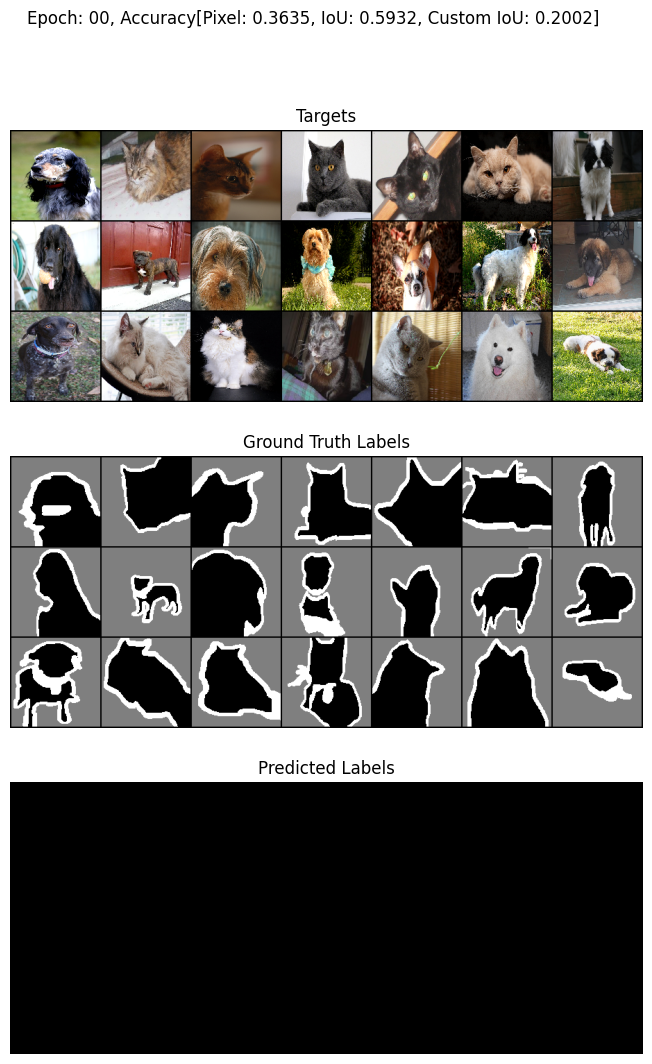

In [19]:
print_test_dataset_masks(m, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)

In [23]:
to_device(m)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


In [21]:
def train_loop(model, loader, test_data, epochs, optimizer, save_path):
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        train_model(model, loader, optimizer)
        with torch.inference_mode():
            # Display the plt in the final training epoch.
            print_test_dataset_masks(model, test_inputs, test_targets, epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))

Epoch: 01, Learning Rate: 0.001


<ipython-input-12-c61111d9766b>:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y= F.softmax(self.conv(x))


Trained 3680 samples, Loss: 0.8665
Epoch: 01, Accuracy[Pixel: 0.7318, IoU: 0.5888, Custom IoU: 0.3062]
Epoch: 02, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7725
Epoch: 02, Accuracy[Pixel: 0.7300, IoU: 0.6116, Custom IoU: 0.3109]
Epoch: 03, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7456
Epoch: 03, Accuracy[Pixel: 0.8086, IoU: 0.6439, Custom IoU: 0.3343]
Epoch: 04, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7267
Epoch: 04, Accuracy[Pixel: 0.8244, IoU: 0.6962, Custom IoU: 0.3408]
Epoch: 05, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7128
Epoch: 05, Accuracy[Pixel: 0.8299, IoU: 0.6279, Custom IoU: 0.3439]
Epoch: 06, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.7059
Epoch: 06, Accuracy[Pixel: 0.8523, IoU: 0.7007, Custom IoU: 0.3513]
Epoch: 07, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.6928
Epoch: 07, Accuracy[Pixel: 0.8646, IoU: 0.7185, Custom IoU: 0.3553]
Epoch: 08, Learning Rate: 0.001
Trained 3680 samples, Loss: 0.6902
Epoch: 08, Accuracy[

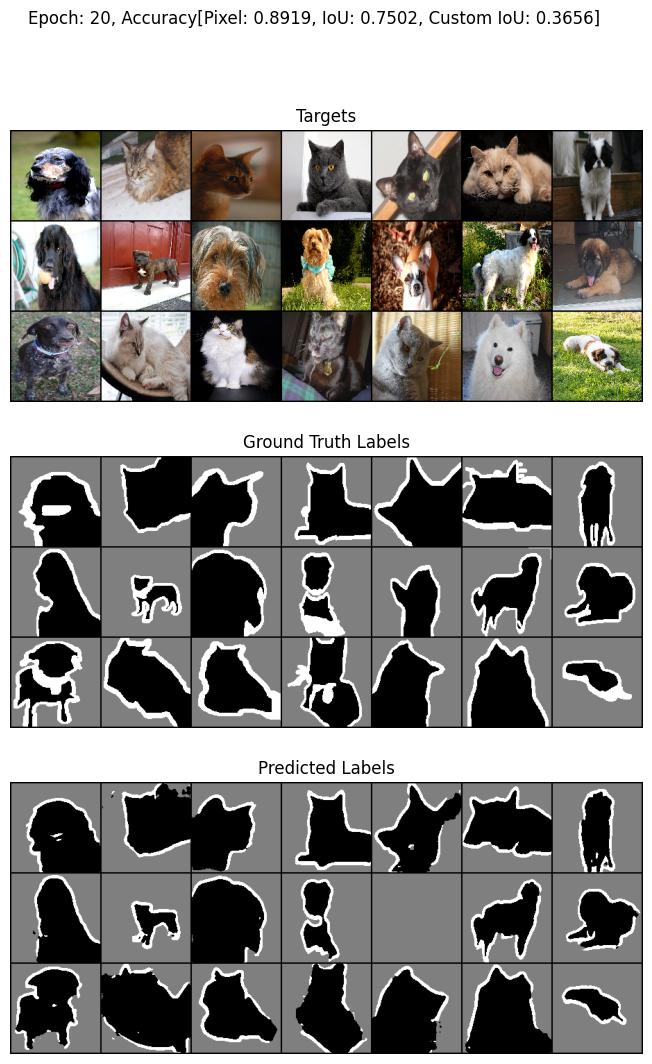

In [22]:
train_loop(m, pets_train_loader, (test_pets_inputs, test_pets_targets), (1, 21), optimizer, save_path=None)